In [1]:
__version__ = '2021-06-26'
__authors__ = ['Robert Nikutta <robert.nikutta@gmail.com>', 'Enrique Lopez-Rodriguez', 'Kohei Ichikawa']

# Hypercat - Morphology
This notebook shows how the `morphology` module in HYPERCAT can be used to investigate morphological quantities of the HYPERCAT brightness maps an the projected dust cloud maps.

## Disclaimer and Attribution
HYPERCAT / CLUMPY models and the accompanyin software were published in two papers. If you decide to make use of either the models, the software, the example notebooks, or the included pupil images of telescopes included with HYPERCAT, please cite these two papers:

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- I. Models and Image Morphology", ApJ (2021, accepted)**

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- II. Resolving the
torus with Extremely Large Telescopes", ApJ (2021, under review)**


## Table of contents
* [Imports & setup](#import)
* [Morphology of the HYPERCAT model images](#morphology)
* [Morphological sizes, elongation, centroid location as function of model parameters](#vsparams)
* [Compare the morphologies of emission with their underlying dust distributions](#compare)
* [From 2D cloud map to real cloud numbers per line of sight](#cldmap2N)
* [Photon escape probability along a line of sight](#pesc)
* [Further information](#furtherinfo)

<a class="anchor" id="import"></a>
## Imports and setup

In [2]:
# std lib
import warnings
warnings.filterwarnings("ignore", message="dataset.value has been deprecated")
from copy import copy

# 3rd party
import numpy as np
from scipy.interpolate import interp1d
import pylab as plt
import matplotlib

# own
import hypercat as hc
from hypercat import morphology
from hypercat import plotting
from hypercat import imageops
print("HYPERCAT version:",hc.__version__)

HYPERCAT version: 0.1.5


<a class="anchor" id="morphology"></a>
## Mophology of the HYPERCAT model images

We load the CLUMPY mode cube, from which we will generate images of AGN tori.

In [3]:
fname = 'hypercat_20181031_all.hdf5' # use your local location to the HDF5 model file
cube = hc.ModelCube(fname,hypercube='imgdata')

Opening HDF5 file: hypercat_20181031_all.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,25,121,241)] to RAM (912.52 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, ...
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 - 160.000]  (  7)    10.000, 20.000, 40.000, 60.000, 80.000,120.000,160.000
wave*    [  1.2

Let's generate a model image with parameters that yield a emission morphology strongly elongated in polar direction:

In [4]:
wave = 4.5
vec = (40,90,20,8,0.08,80,wave)  # thes are the values for: sig [degrees], i [degrees], Y, N, q, tv, wave [micron]
img = cube(vec)

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.


We also generate a version of this model rotated 30 degrees counter-clockwise:

In [5]:
rot = imageops.rotateImage(img,'30 deg')

And plot them together:

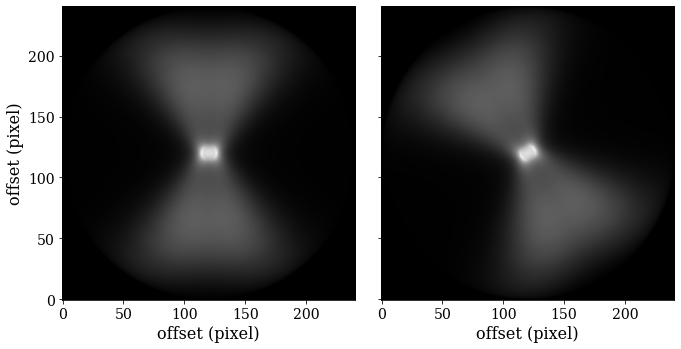

In [6]:
plotting.multiplot((img,rot),panelsize=5,cmaps='gray',colorbars=None);

Using the functions in HYPERCAT's `morphology` module we can compute several morphological quantities, e.g.:
- position angle
- location of the image centroid
- size in x and y directions
- elongation
- Gini coefficient

In [7]:
def morpho_stats(img):
    print("Position angle PA = %g deg" % morphology.get_angle(img))
    print("Centroid location (x,y) = (%.2f,%.2f)" % morphology.get_centroid(img)[1:])
    print("Radii of gyration rgx, rgy = (%.2f,%.2f)" % morphology.get_rgyr(img))
    print("Elongation = %.2f" % morphology.get_elongation(img))
    print("Gini coefficient G = %.2f" % morphology.gini(img))

print("Original model:")
morpho_stats(img)

print()

print("Rotated model:")
morpho_stats(rot)

Original model:
Position angle PA = 0 deg
Centroid location (x,y) = (120.00,120.00)
Radii of gyration rgx, rgy = (34.19,62.39)
Elongation = 1.82
Gini coefficient G = 0.64

Rotated model:
Position angle PA = 30.0027 deg
Centroid location (x,y) = (120.00,120.00)
Radii of gyration rgx, rgy = (43.01,56.66)
Elongation = 1.82
Gini coefficient G = 0.64


Conclusions:

- The polar elongation of the model is correctly captured.
- The centroid location is at the image center for these model parameters.
- While the radii of gyration (sizes in x and y directions) change with position angle, their ratio (elongation of the morphology) is invariant under rotations. This is a very desirable property for our goal of measuring elongations of AGN morphologies.

Note also that the measured position angles correspond to the angles we selected for generating the model images. If we however change the CLUMPY parameters a bit:

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.


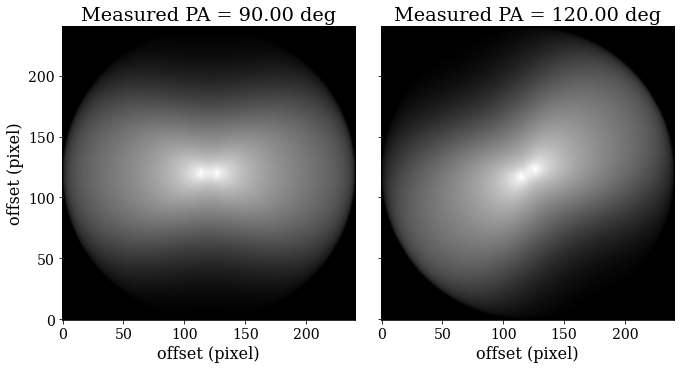

In [8]:
wave = 53
vec = (40,90,20,8,0.08,80,wave)  # thes are the values for: sig [degrees], i [degrees], Y, N, q, tv, wave [micron]
img = cube(vec)
rot = imageops.rotateImage(img,'30 deg')

template = "Measured PA = %.2f deg"
titles = [template % morphology.get_angle(img), template % morphology.get_angle(rot)]
plotting.multiplot((img,rot),panelsize=5,cmaps='gray',colorbars=None,titles=titles);

Let's print our standard morphology measures again:

In [9]:
print("Original model:")
morpho_stats(img)

print()

print("Rotated model:")
morpho_stats(rot)

Original model:
Position angle PA = 90 deg
Centroid location (x,y) = (120.00,120.00)
Radii of gyration rgx, rgy = (58.29,40.25)
Elongation = 0.69
Gini coefficient G = 0.51

Rotated model:
Position angle PA = 120.004 deg
Centroid location (x,y) = (120.00,120.00)
Radii of gyration rgx, rgy = (54.33,45.43)
Elongation = 0.69
Gini coefficient G = 0.51


Conclusions:

- This model's morpology is extended in the x-direction (equatorial plane of the torus). Consequently, the elongation is below unity.
- The PA as measured corresponds to the dominant elongation direction. I.e. 90 degrees in the non-rotated image, and 90+30=120 degrees for the image rotated by 30 degrees from the torus axis (which co-aligns with North).

For the remainder of this notebook we can forgo any image rotations and focus on the morphological measurements of e.g. size, elongation, centroid location, and image compactness.

<a class="anchor" id="vsparams"></a>
## Morphological sizes, elongation, centroid location as function of model parameters
We can use the radii of gyration to measure morphological sizes independently in the x and y directions. Let's try this as a function of viewing angle, for one wavelength.

Loading a subcube of 71.1938 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.


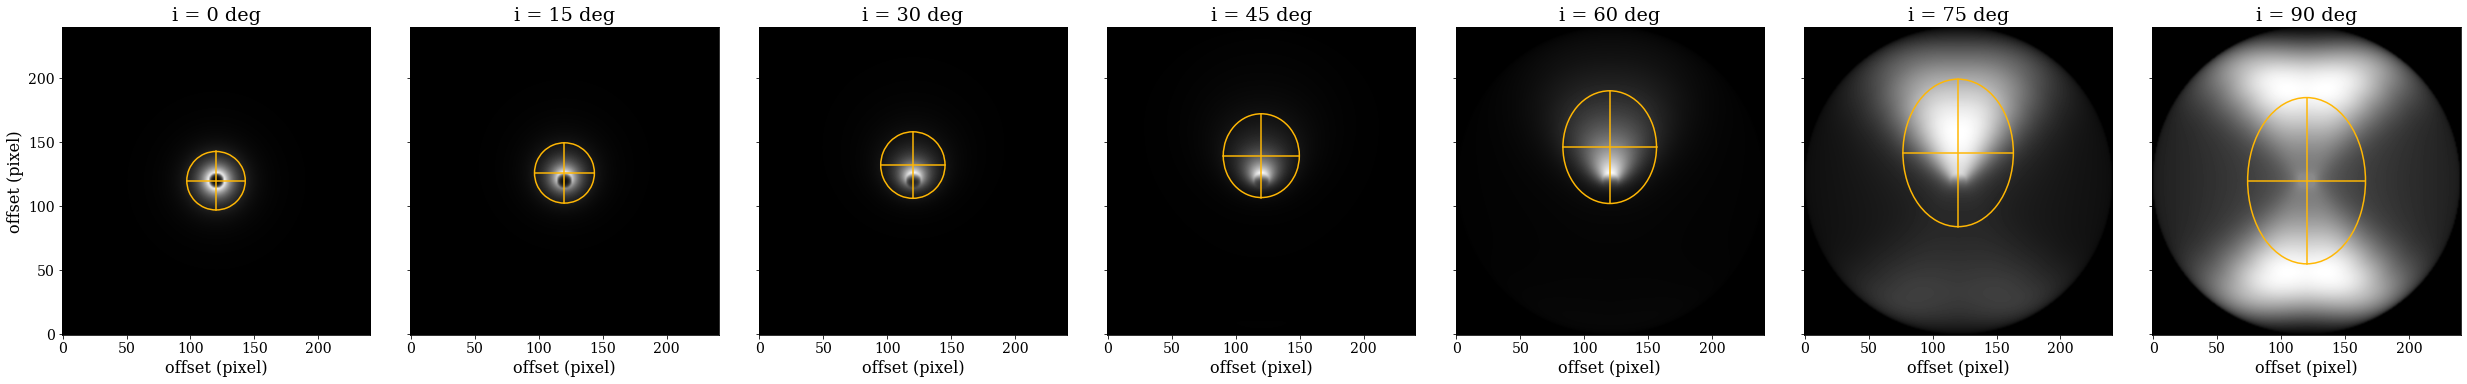

In [10]:
wave = 10
i = (0,15,30,45,60,75,90)
n = len(i)

vec = (40,i,20,8,0.08,80,wave)  # these are the values for: sig [degrees], i [degrees], Y, N, q, tv, wave [micron]
imgcube = cube(vec)  # generates 3d model cube, one image (slice) per viewing angle i
images = [imgcube[j,...] for j in range(n)]  # flatten the 3d cube (make list of image slices)

# Plot images
titles = ["i = %d deg" % i_ for i_ in i]
fig, axes = plotting.multiplot(images,cmaps='gray',colorbars=None,panelsize=5,titles=titles);

# Placeholders for morphological measurements
rgxvals, rgyvals, ycvals = np.empty(n), np.empty(n), np.empty(n)  # x and y radii of gyration, y-location of image centroid (all in pixels) 

# for each image, measure morphological quantities, and overplot ellipse of gyration radii
for j in range(n):
    ax = axes[0][j]
    img = images[j]
    
    # gyration radii & ellipse
    rgx, rgy = morphology.get_rgyr(img)
    rgxvals[j] = rgx
    rgyvals[j] = rgy
    M00, xc, yc = morphology.get_centroid(img)  # 0-order moment, xcentroid, ycentroid
    ycvals[j] = yc

    # plot the ellipse axes
    c = '#ffb704'
    ax.plot((xc-rgx,xc+rgx),(yc,yc),ls='-',color=c,lw=1.5)
    ax.plot((xc,xc),(yc-rgy,yc+rgy),ls='-',color=c,lw=1.5)

    # plot the ellipse
    arc = matplotlib.patches.Arc((xc,yc), 2*rgx, 2*rgy, angle=0.0, theta1=0.0, theta2=360.0, zorder=2,\
                                  edgecolor=c, ls='-', lw=1.5)
    ax.add_artist(arc);

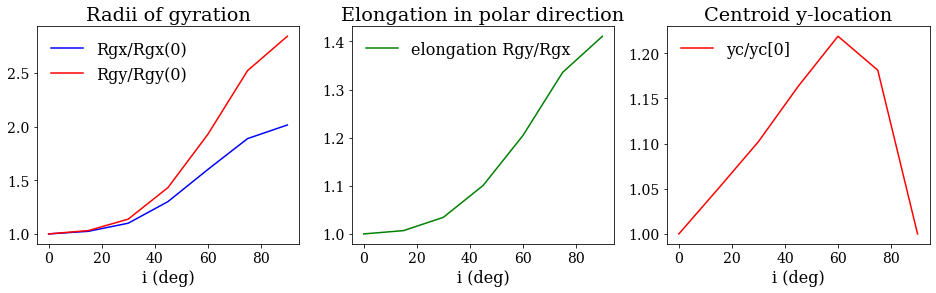

In [11]:
# make figure with 3 panels
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4))

# function to plot a single panel
def plot_panel(ax,x,y,style,label='',title=''):
    ax.plot(x,y,style,label=label)
    ax.set_xlabel('i (deg)')
    ax.set_title(title)
    ax.legend(frameon=0);

# panel 1: x and y morphological sizes (measured as radii of gyration)
plot_panel(ax1,i,rgxvals/rgxvals[0],'b-',label='Rgx/Rgx(0)')
plot_panel(ax1,i,rgyvals/rgyvals[0],'r-',label='Rgy/Rgy(0)',title='Radii of gyration')

# panel 2: elongation of image morphology in y-direction
plot_panel(ax2,i,rgyvals/rgxvals,'g-',label='elongation Rgy/Rgx',title='Elongation in polar direction')

# panel 3: y-location of image centroid
plot_panel(ax3,i,ycvals/ycvals[0],'r-',label='yc/yc[0]',title='Centroid y-location')

For this particular model we see that:
- both the x and y morphological sizes grow with viewing angle (but y-size grows faster)
- consequently, the y/x morphology elongation (i.e. in polar direction) grows from 1.0 (circular) at i=0 deg to 1.4 (elongated) for i=90 deg
- The image centroid location moves along the y-axis as a function of viewing angle. By construction, yc must be at the image center for both i=0 and i=90 deg.

<a class="anchor" id="compare"></a>
## Compare the morphologies of emission with their underlying dust distributions 

In [12]:
# thes are the values for: sig [degrees], i [degrees], Y, N, q, tv, wave [micron]
sig, i, Y, N0, q, tv = 40, 90, 20, 8, 0.08, 80
waves = (2.2,10,53,350)
n = len(waves)

vecimg = (sig,i,Y,N0,q,tv,waves)
aux = cube(vecimg)
images = [aux[j,...] for j in range(n)]

# load dust cloud hypercube
cldcube = hc.ModelCube(fname,hypercube='clddata')

# load corresponding dust 2D map
veccld = (sig,i,Y,q)  # recall that the dust map morphologies do not depend on N, tv, and wave
cldimg = cldcube(veccld)

Loading a subcube of 156.626 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Opening HDF5 file: hypercat_20181031_all.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'clddata' [shape: (5,10,16,5,121,241)] to RAM (444.96 MB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
  i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, ...
  Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, ...
  q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  x     [  0.000 - 120.000]  (121)     0.000,  1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000, ...
 

Now let's plot the dust 2D map, and the emission morphologies that it generates at various wavelengths. We overplot the dust 2D map as contours in the emission panels.

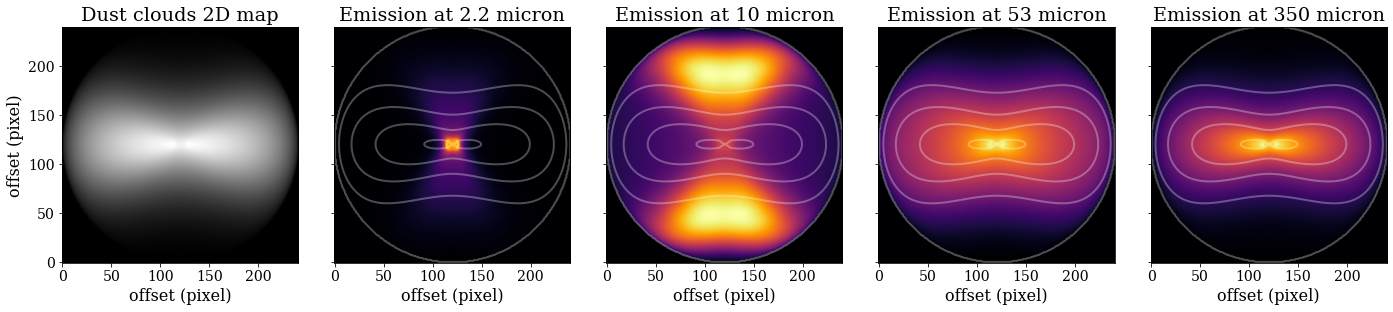

In [13]:
cmaps = ['gray'] + ['inferno']*n
titles = ['Dust clouds 2D map'] + ["Emission at %g micron" % wave for wave in waves]
fig, axes = plotting.multiplot([cldimg] + images,cmaps=cmaps,colorbars=None,titles=titles);

for j in range(n):
    ax = axes[0][j+1]
    ax.contour(cldimg.T,origin='lower',levels=4,colors='white',linewidths=2,alpha=0.3)

The emission morphology follows the underlying dust morphology only at longer wavelengths, i.e. when the emission is more optically thin.

Let's now measure the morphology elongation of the dust map and of the emission maps at the different wavelengths:

In [14]:
print("y/x elongation of the 2D dust morphology: e = %.2f" % morphology.get_elongation(cldimg))

for j,img in enumerate(images):
    w = waves[j]
    print("y/x elongation of the 2D emission morphology at %g micron: e = %.2f" % (w,morphology.get_elongation(img)))

y/x elongation of the 2D dust morphology: e = 0.59
y/x elongation of the 2D emission morphology at 2.2 micron: e = 1.79
y/x elongation of the 2D emission morphology at 10 micron: e = 1.41
y/x elongation of the 2D emission morphology at 53 micron: e = 0.69
y/x elongation of the 2D emission morphology at 350 micron: e = 0.59


Conclusions:

- The dust morphology defines the torus, and is strongly elongated in the x-direction (equatorial) plane, with e = 0.59.
- At 2.2 and 10 micron the opaqueness of the torus allows photons only to escape through less dense regions above the torus plane, leading to the observed polar elongations (1.79 and 1.41 for 2.2 and 10 micron, respectively)
- At FIR wavelengths the torus is optically thin and the emission morphology follows closely the dust morphology, with similar equatorial elongations.

<a class="anchor" id="cldmap2N"></a>
## From 2D cloud map to real cloud numbers per line of sight

The value of each pixel in `cldimg` is the mean cloud number per LOS (i.e., per-pixel), but normalized to the case where $N_0=1$. 

Since our model here is viewed edge-on (in the equatorial plane), and we know from the CLUMPY model that the parameter $N_0$ is the mean number of clouds per radial ray in the equatorial plane, we should find that number when inspecting the central pixel in the 2D cloud map:

In [15]:
cpix = cldimg.shape[0]//2  # find the central pixel index

# what's the number of clouds along the central radial ray? (counting both sides of the torus!)
print("Number of clouds along LOS through central pixel:", cldimg[cpix,cpix])

Number of clouds along LOS through central pixel: 2.0000007


Note that this is $2 \times N_0$ because both the front and back side of the torus are counted.

To compute the true line of sight (LOS) mean number of clouds (through every pixel), simply multiply the 2D cloud map by the desired N0:

In [16]:
nclouds = cldimg * N0
print("Number of clouds along LOS through central pixel:", nclouds[cpix,cpix])

Number of clouds along LOS through central pixel: 16.000006


<a class="anchor" id="pesc"></a>
## Photon escape probability along a line of sight

We saw above that the emission morphology resembles the dust cloud distribution morhology only at FIR wavelengths, when the total optical depth per path becomes small. We can quantify the "transmissiveness" of the torus by computing the wavelength-dependent photon escape probability $P_{esc}$. From Eq. (4) in Nenkova+2008a, $P_{esc}$ through a column of $\it{N}$ clouds is:

$P_{esc} = \exp(-t_\lambda)$

where

$t_{\lambda} = N \times \{1-\exp(-\tau_{\lambda})\}$

is the total optical depth of $N$ clouds, and $\tau_{\lambda}$ is the optical depth of a single cloud at wavelength $\lambda$.

To compute $\tau_{\lambda}$ we use the dust opacity curve of standard ISM dust mixture of 53 percent silicates with optical properties from Ossenkopf, Henning, Mathis (1992, A&A), and 47 percent graphites with optical properties from Draine (2003, ApJ). The dust grains are spherical with a power-law size distribution after Mathis, Rumpl, Nordsieck (1977, ApJ). The wavelength-dependent tabulation of the dust opacity curve (the same one used to compute the HYPERCAT models) is provided with the HYPERCAT software. It is the same one that was used in Nenkova et al (2008a,b, ApJ) for the CLUMPY model SEDs.

First, let's construct a 1D interpolator and a function such that we can obtain $\tau_{\lambda}$ at any wavelength. We must take into account that the CLUMPY cloud optical depths are given normalized to the V band, i.e. at 0.55 micron. That is, we divide each $\tau_{\lambda}$ by $\tau_{0.55 \mu m}$.

In [17]:
lam, abso, scat = np.loadtxt('../data/ISM-OHM.dat',skiprows=3,unpack=True) # load lambda, absorption, scattering components
tot = abso + scat  # total dust opacity = absorption component + scattering component
ip = interp1d(lam,tot,kind='cubic')  # make a 1D interpolation object
norm = ip(0.55)  # CLUMPY/HYPERCAT models are normalized to tau(0.55micron) = V-band

def taulam(wave):
    """Return optical depth of single cloud at wavelength `wave`."""
    return ip(wave)/norm

We test that at $\tau_V = 1$ the value of $\tau_\lambda$ is indeed unity at 0.55 micron:

In [18]:
1*taulam(0.55)

1.0

We can plot this optical depth function for a range od wavelengths:

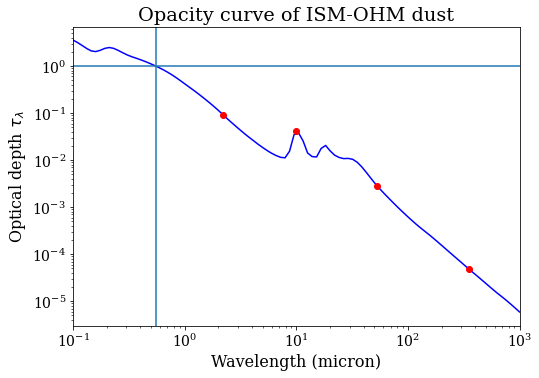

In [19]:
x = np.logspace(-1,3,100) # 100 log-spaced wavelengths between 0.1 and 1000 micron
y = taulam(x)
x2 = waves
y2 = taulam(x2)
fig, ax = plt.subplots(1,1,figsize=(8,5.5))
ax.loglog(x,y,'b-')
ax.loglog(x2,y2,'ro')  # also indicate the wavelengths of the images used above
ax.axhline(1)  # indicate normalization point
ax.axvline(0.55)  # indicate normalization point
ax.set_xlim(x.min(),x.max())
ax.set_xlabel('Wavelength (micron)')
ax.set_ylabel(r'Optical depth $\tau_\lambda$')
ax.set_title('Opacity curve of ISM-OHM dust');

The enhanced optical depth at the 10 and 18-micron silicate features are clearly visible.

Now on to the photon escape probability $P_{esc}$. From Eq. (4) in Nenkova+2008a we can compute $P_{esc}$ through a column of $N$ clouds:

$P_{esc} = \exp(-t_\lambda)$

where

$t_{\lambda} = N \times \{1-\exp(-\tau_{\lambda})\}$

and $\tau_{\lambda}$ is the optical depth of a single cloud at wavelength $\lambda$.

We define a function that for given values of $N_0$, $\tau_V$, and a wavelength returns the 2D map of photon escape probability, if one were to imagine background photons traversing through the entire torus in our 2D cloud map `cldimage` from before: 

In [20]:
def get_pesc(N0,tv,lam):
    cldimg_masked = np.ma.masked_where(cldimg == 0, cldimg)  # masking the areas outside the torus for viz purposes later
    t = N0 * cldimg_masked * (1-np.exp(-tv*taulam(lam)))
    pescmap = np.exp(-t)

    return pescmap

Let's compute the 2D maps of photon escape probability for the wavelengths we used above:

In [21]:
pescmaps = [get_pesc(N0,tv,wave) for wave in waves]

And finally we plot the $P_{esc}$ maps:

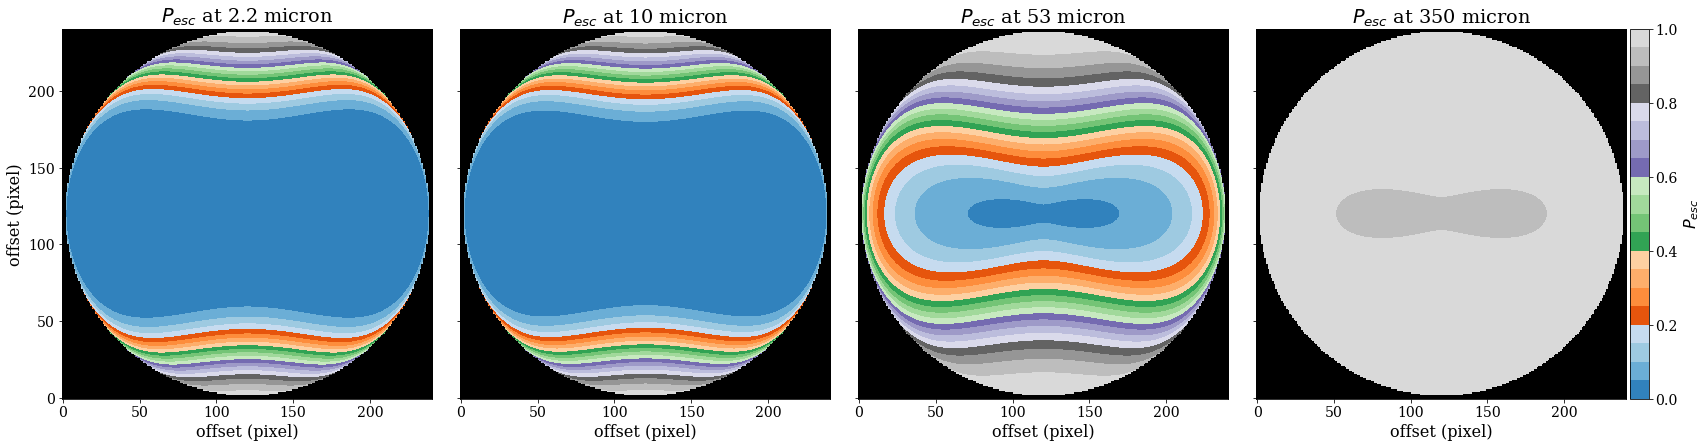

In [22]:
titles = [r"$P_{esc}$ at %g micron" % wave for wave in waves]  # panel titles
colorbars = [False]*(len(waves)-1) + [True] # colorbars yes or no per panel
cblabels = [None]*(len(waves)-1) + [r'$P_{esc}$']  # colorbar labels

# modifying the colormap a bit to take care of the areas outside the torus
palette = copy(plt.cm.tab20c)
palette.set_bad('k',1)

fig, axes = plotting.multiplot(pescmaps,cmaps=palette,panelsize=6,norm=matplotlib.colors.Normalize(0,1),
                               colorbars=colorbars,cblabels=cblabels,titles=titles);

The maps of photon escape probability are very opaque for NIR and MIR wavelength. Only the regions high above the torus equatorial plane reach $P_{esc}$ > 50 percent. Note also how the maps at 2.2 and 10 micron are very similar; this is because the dust opacity curve (see plot further above) reaches similar values thanks to the silicate feature enhancement at 10 micron.

At FIR and sub-mm wavelengths however, the torus itself becomes transparent, and photons can travel much more unimpeded.

<a class="anchor" id="furtherinfo"></a>
## Further information
* To learn how HYPERCAT's morphological functions can be used in details, please see this notebook: https://github.com/rnikutta/hypercat/tree/master/examples/04-hypercat-morphology-intro.ipynb
* For a demonstration of other capabilities of HYPERCAT, please check out the various other notebooks in: https://github.com/rnikutta/hypercat/tree/master/examples/